# MNIST Image Classification with PyTorch


**MNIST dataset**.

By the end of this notebook, you will have gone through the entire end-to-end process. Specifically, you will:
- **Prepare your data:** Load the MNIST dataset, inspect its format, and apply essential transformations.  
- **Build your model:** Define a custom neural network using PyTorch’s flexible `nn.Module` class.  
- **Train your model:** Implement the full training process with a loss function, optimizer, and training loop.  
- **Analyze your results:** Evaluate your model on unseen data and visualize its performance.

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import helper_utils

* The code below selects the best available hardware on your system to speed up model training.
    * **CUDA**: Runs on NVIDIA GPUs, which are widely used for deep learning and typically offer the fastest training performance.
    * **MPS**: Runs on Apple Silicon GPUs, providing efficient acceleration on modern Mac systems.
    * **CPU**: Runs on the Central Processing Unit, the standard processor every computer has. PyTorch will automatically use it if no compatible GPU is detected.  

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print(f"Using device: CPU")

Using device: CPU


## MNIST Dataset: Preparing your Data

The [MNIST dataset](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) is a classic benchmark for image classification and is often considered the “hello world” of computer vision. It contains 60,000 training images and 10,000 test images. Each image is 28 by 28 pixels, in grayscale, showing a single handwritten digit from 0 to 9.

In [4]:
# Set the path to store the dataset files
data_path = "./content"

In [9]:
train_dataset_without_transform = torchvision.datasets.MNIST(
    root=data_path,     # Path to the directory where the data is/will be stored
    train=True,         # Specify that you want the training split of the dataset
    download=True       # Download the data if it's not found in the root directory
)

In [10]:
# Get the first sample (index 0), as a (image, label) tuple
image_pil, label = train_dataset_without_transform[0] # Get the first image

print(f"Image type:        {type(image_pil)}")
# Since `image_pil` is a PIL Image object, its dimensions are accessed using the .size attribute.
print(f"Image Dimensions:  {image_pil.size}")
print(f"Label Type:        {type(label)}")
print(f"Label value:       {label}")

Image type:        <class 'PIL.Image.Image'>
Image Dimensions:  (28, 28)
Label Type:        <class 'int'>
Label value:       5


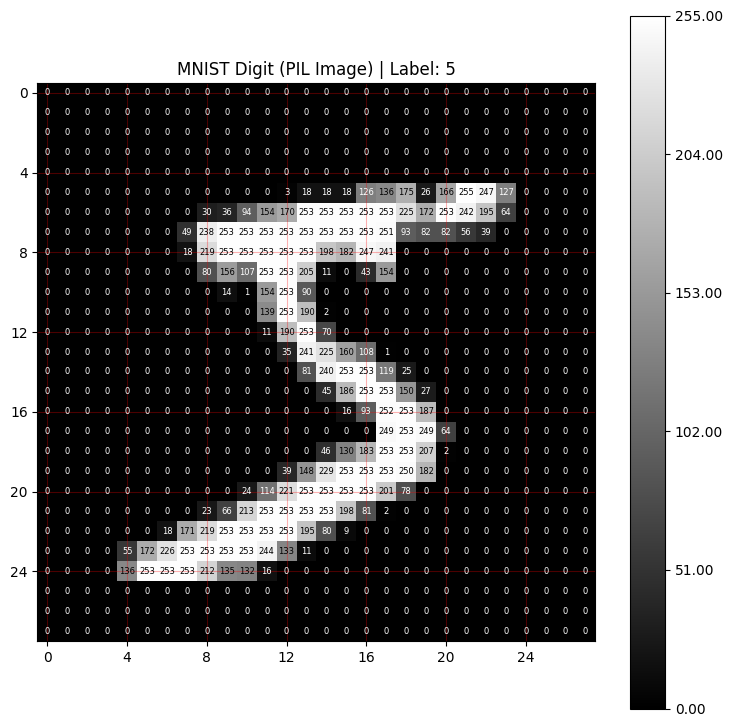

In [11]:
# Visualize the sample image and its corresponding label
helper_utils.display_image(image_pil, label, "MNIST Digit (PIL Image)", show_values=True)

In [13]:
# Convert images to tensors and normalize pixel values
# Pixel values are scaled to [0, 1] and then standardized to mean 0 and std 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

In [14]:
train_dataset = torchvision.datasets.MNIST(
    root=data_path,     # Path to the directory where the data is/will be stored
    train=True,         # Specify that you want the training split of the dataset
    download=True,      # Download the data if it's not found in the root directory
    transform=transform # Apply the defined transformations to each image
)

In [15]:
# Access the first item again
image_tensor, label = train_dataset[0]

print(f"Image Type:                   {type(image_tensor)}")
# Since the `image` is now a PyTorch Tensor, its dimensions are accessed using the .shape attribute.
print(f"Image Shape After Transform:  {image_tensor.shape}")
print(f"Label Type:                   {type(label)}")
print(f"Label value:                  {label}")


Image Type:                   <class 'torch.Tensor'>
Image Shape After Transform:  torch.Size([1, 28, 28])
Label Type:                   <class 'int'>
Label value:                  5


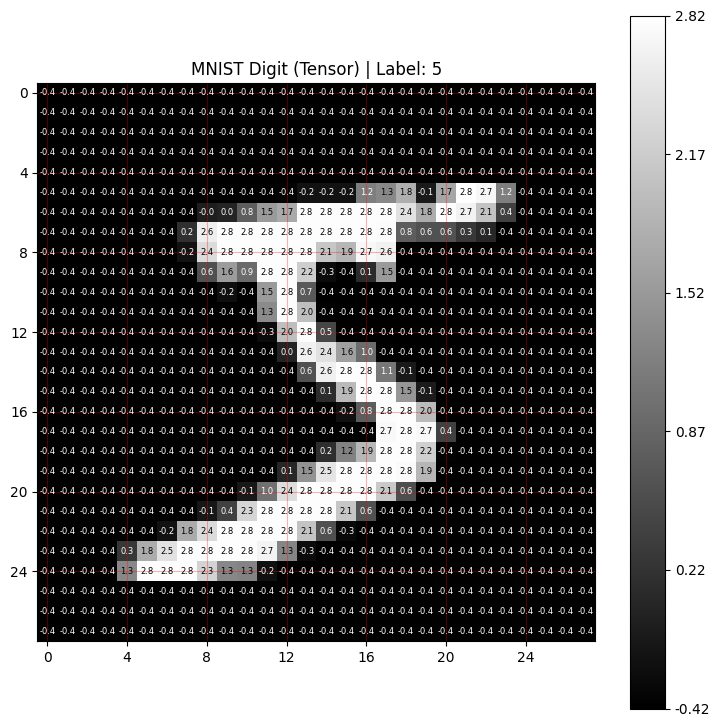

In [16]:
# Visualize the transformed image and its label
helper_utils.display_image(image_tensor, label, "MNIST Digit (Tensor)", show_values=True)

#### Load the Test Dataset


In [17]:
test_dataset = torchvision.datasets.MNIST(
    root=data_path,     # Path to the directory where the data is/will be stored
    train=False,        # Specify that you want the testing split of the dataset
    download=True,      # Download the data if it's not found in the root directory
    transform=transform # Apply the defined transformations to each image
)

#### Create Data Loaders


In [18]:
# Create a data loader for the training set with shuffling enabled
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create a data loader for the test set with a larger batch size and no shuffling
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

## Building the Neural Network Model


In [19]:
class SimpleMNISTDNN(nn.Module):
    """
    A simple deep neural network model for the MNIST dataset.

    This model consists of a flatten layer followed by two linear layers
    with a ReLU activation function. It is designed for classification tasks
    on 28x28 grayscale images.
    """
    def __init__(self):
        """
        Initializes the layers of the neural network.
        """
        super(SimpleMNISTDNN, self).__init__()
        # Initializes a layer to flatten the input tensor.
        # 28x28 input image to a 784-dimensional vector.
        self.flatten = nn.Flatten()
        # Initializes the sequential layers of the neural network
        self.layers = nn.Sequential(
            # Defines the first linear layer with 784 input features and 128 output features.
            nn.Linear(784, 128),
            # Applies the rectified linear unit activation function.
            nn.ReLU(),
            # Defines the second linear layer with 128 input features and 10 output features.
            nn.Linear(128, 10)
        )

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Args:
            x: The input tensor.

        Returns:
            The output tensor after passing through the network layers.
        """
        # Flattens the input tensor.
        x = self.flatten(x)
        # Passes the flattened tensor through the sequential layers.
        x = self.layers(x)
        return x

## Training the Model


In [20]:
# Initialize the neural network model
model = SimpleMNISTDNN()

# Define the loss function, suitable for multi-class classification
loss_function = nn.CrossEntropyLoss()

# Set up the Adam optimizer to update the model's parameters with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Define the Training Function


this function performs these key operations:

* **Model Preparation**: Before iterating over the data, it prepares the model by moving it to the correct `device` and setting it to training mode with `model.train()`.

* **Core Training Loop**: For each batch of data, it executes the essential five-step training sequence: clearing gradients, running a forward pass, calculating loss, performing backpropagation, and updating the model's weights.

* **Progress Reporting**: Finally, it tracks the running loss and accuracy, printing periodic updates to monitor how well the model is learning.
    * Specifically, with **60,000** training images and a batch size of **64**, the function will report its progress every **134 steps**, giving you **7** consistent updates throughout the epoch.

In [21]:
def train_epoch(model, loss_function, optimizer, train_loader, device):
    """
    Trains a PyTorch model for a single epoch.

    This function iterates over the training dataset, performs the forward and
    backward passes, and updates the model's weights. It also tracks and
    prints the loss and accuracy at specified intervals.

    Args:
        model: The neural network model to be trained.
        loss_function: The loss function used to calculate the error.
        optimizer: The optimizer used to update the model's weights.
        train_loader: The DataLoader providing batches of training data.
        device: The device (e.g., 'cuda' or 'cpu') on which to perform training.

    Returns:
        A tuple containing:
        - model: The model after training for one epoch.
        - avg_epoch_loss: The average loss calculated over all batches in the epoch.
    """
    # Ensure the model is on the correct device for training
    model = model.to(device)
    # Set the model to training mode
    model.train()

    # Initialize trackers for the entire epoch's loss
    epoch_loss = 0.0

    # Initialize trackers for periodic progress reporting
    running_loss = 0.0
    num_correct_predictions = 0
    total_predictions = 0
    total_batches = len(train_loader)

    # Iterate over the training data in batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move the current batch of data to the specified device
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear any gradients from the previous iteration
        optimizer.zero_grad()

        # Perform a forward pass to get model predictions
        outputs = model(inputs)

        # Calculate the loss for the current batch
        loss = loss_function(outputs, targets)

        # Perform backpropagation to compute gradients
        loss.backward()

        # Update the model's weights based on the computed gradients
        optimizer.step()

        # Accumulate the loss for tracking and reporting
        loss_value = loss.item()
        epoch_loss += loss_value
        running_loss += loss_value

        # Calculate accuracy metrics for the current batch
        _, predicted_indices = outputs.max(1)
        batch_size = targets.size(0)
        total_predictions += batch_size
        num_correct_in_batch = predicted_indices.eq(targets).sum().item()
        num_correct_predictions += num_correct_in_batch

        # Check if it's time to print a progress update
        if (batch_idx + 1) % 134 == 0 or (batch_idx + 1) == total_batches:
            # Calculate average loss and accuracy for the current interval
            avg_running_loss = running_loss / 134
            accuracy = 100. * num_correct_predictions / total_predictions

            # Print the progress update
            print(f'\tStep {batch_idx + 1}/{total_batches} - Loss: {avg_running_loss:.3f} | Acc: {accuracy:.2f}%')

            # Reset the trackers for the next reporting interval
            running_loss = 0.0
            num_correct_predictions = 0
            total_predictions = 0

    # Calculate the average loss for the entire epoch
    avg_epoch_loss = epoch_loss / total_batches
    # Return the trained model and the average epoch loss
    return model, avg_epoch_loss

### Define the Evaluation Function


In [23]:
def evaluate(model, test_loader, device):
    """
    Evaluates the model's accuracy on a test dataset.

    This function sets the model to evaluation mode, iterates through the test data,
    and calculates the percentage of correct predictions.

    Args:
        model: The neural network model to be evaluated.
        test_loader: A data loader containing the test dataset.
        device: The device (e.g., 'cpu' or 'cuda') to run the evaluation on.

    Returns:
        The accuracy of the model on the test dataset as a percentage.
    """
    # Sets the model to evaluation mode.
    model.eval()
    # Initializes a counter for correct predictions.
    num_correct_predictions = 0
    # Initializes a counter for the total number of predictions.
    total_predictions = 0

    # Disables gradient calculation to reduce memory usage and speed up computations.
    with torch.no_grad():
        # Iterates over all batches in the test data loader.
        for inputs, targets in test_loader:
            # Moves the input data and targets to the specified device.
            inputs, targets = inputs.to(device), targets.to(device)

            # Performs a forward pass to get the model's output.
            outputs = model(inputs)

            # Retrieves the index of the highest value in the output tensor, which represents the predicted class.
            _, predicted_indices = outputs.max(1)

            # Gets the size of the current batch.
            batch_size = targets.size(0)
            # Adds the batch size to the total number of predictions.
            total_predictions = total_predictions + batch_size

            # Compares the predicted indices with the actual target values.
            correct_predictions = predicted_indices.eq(targets)
            # Sums the correct predictions in the current batch.
            num_correct_in_batch = correct_predictions.sum().item()
            # Adds the correct predictions from the current batch to the total count.
            num_correct_predictions = num_correct_predictions + num_correct_in_batch

    # Calculates the overall accuracy as a percentage.
    accuracy_percentage = (num_correct_predictions / total_predictions) * 100
    # Prints the calculated accuracy to the console.
    print((f'\tAccuracy - {accuracy_percentage:.2f}%'))

    return accuracy_percentage

### The Training Loop


In [24]:
# Set the total number of training epochs (Feel free to set a different number)
num_epochs = 5

# Initialize lists to store metrics from each epoch for later analysis
train_loss = []
test_acc = []

# Begin the training and evaluation process
for epoch in range(num_epochs):
    print(f'\n[Training] Epoch {epoch+1}:')
    # Call the training function to train the model for one epoch
    trained_model, loss = train_epoch(model, loss_function, optimizer, train_loader, device)
    # Store the average training loss for the epoch
    train_loss.append(loss)

    print(f'[Testing] Epoch {epoch+1}:')
    # Call the evaluation function to measure performance on the test set
    accuracy = evaluate(trained_model, test_loader, device)
    # Store the test accuracy for the epoch
    test_acc.append(accuracy)


[Training] Epoch 1:
	Step 134/938 - Loss: 0.566 | Acc: 83.54%
	Step 268/938 - Loss: 0.292 | Acc: 90.95%
	Step 402/938 - Loss: 0.250 | Acc: 92.50%
	Step 536/938 - Loss: 0.205 | Acc: 93.90%
	Step 670/938 - Loss: 0.181 | Acc: 94.48%
	Step 804/938 - Loss: 0.171 | Acc: 95.02%
	Step 938/938 - Loss: 0.162 | Acc: 95.10%
[Testing] Epoch 1:
	Accuracy - 96.16%

[Training] Epoch 2:
	Step 134/938 - Loss: 0.117 | Acc: 96.56%
	Step 268/938 - Loss: 0.132 | Acc: 96.19%
	Step 402/938 - Loss: 0.119 | Acc: 96.70%
	Step 536/938 - Loss: 0.116 | Acc: 96.62%
	Step 670/938 - Loss: 0.120 | Acc: 96.35%
	Step 804/938 - Loss: 0.095 | Acc: 97.18%
	Step 938/938 - Loss: 0.098 | Acc: 97.07%
[Testing] Epoch 2:
	Accuracy - 97.09%

[Training] Epoch 3:
	Step 134/938 - Loss: 0.081 | Acc: 97.49%
	Step 268/938 - Loss: 0.081 | Acc: 97.39%
	Step 402/938 - Loss: 0.074 | Acc: 97.75%
	Step 536/938 - Loss: 0.081 | Acc: 97.39%
	Step 670/938 - Loss: 0.080 | Acc: 97.45%
	Step 804/938 - Loss: 0.081 | Acc: 97.57%
	Step 938/938 - Loss:

## Analyzing Model Performance


With the training complete, the final step is to analyze your model's performance. You'll do this in two ways: **qualitatively**, by looking at some of its specific predictions, and **quantitatively**, by plotting its performance metrics over time.

### Visualizing Predictions


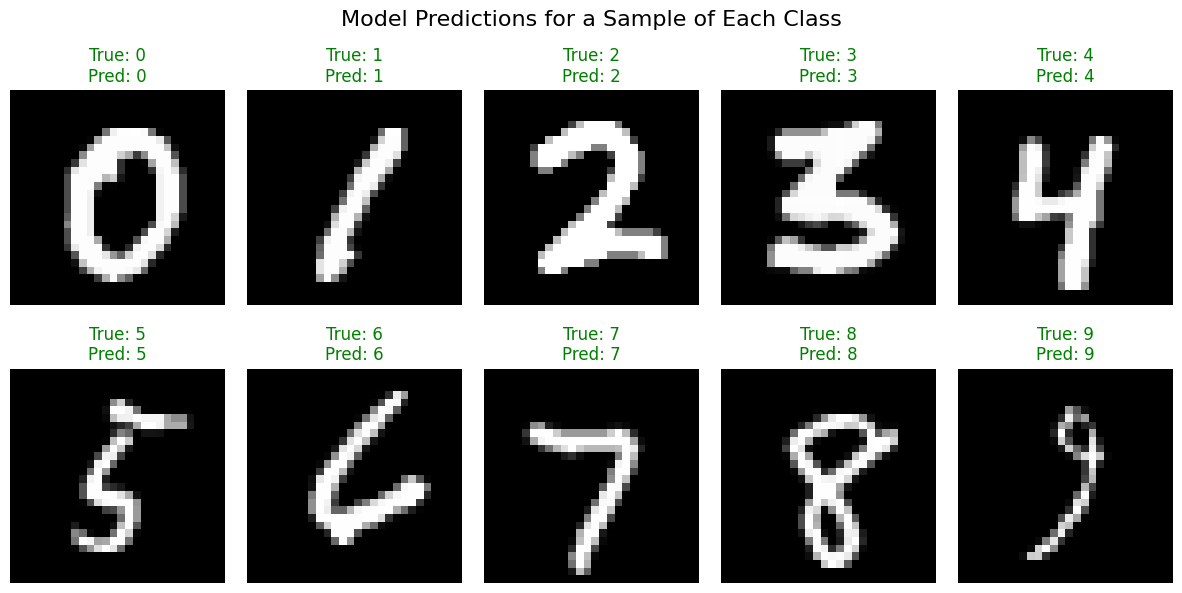

In [25]:
# Visualize model predictions on a random sample of test images
helper_utils.display_predictions(trained_model, test_loader, device)

### Plotting Performance Metrics


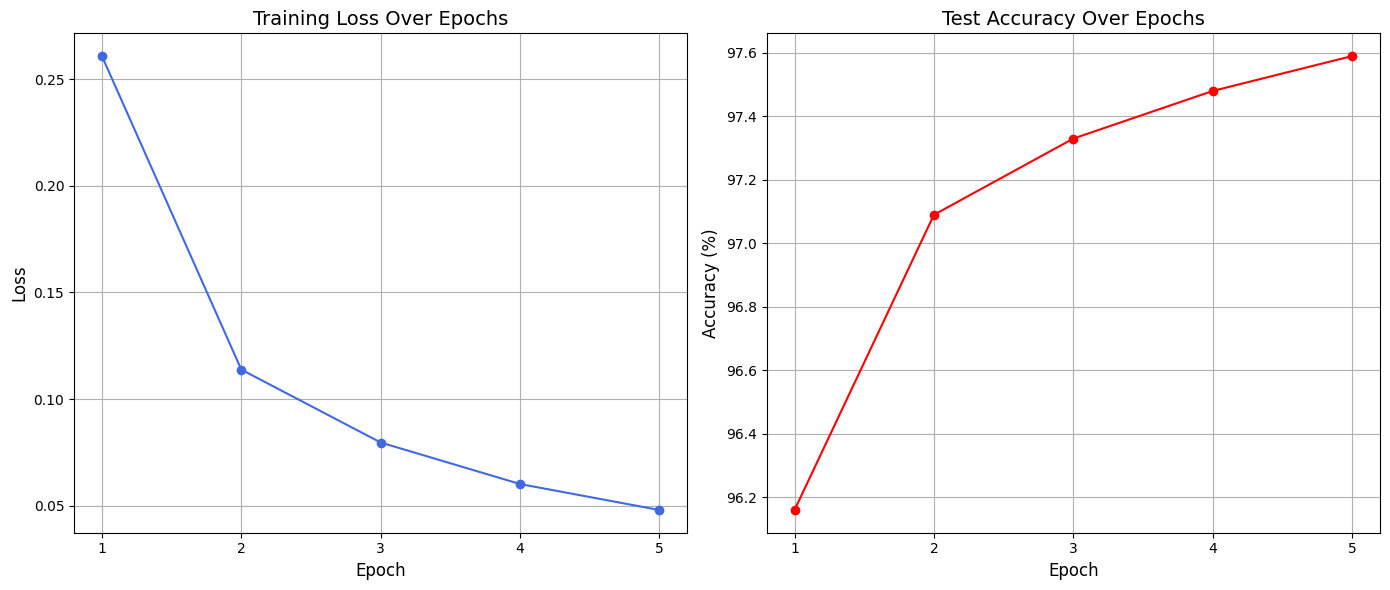

In [26]:
# Plot the training loss and test accuracy curves over all epochs
helper_utils.plot_metrics(train_loss, test_acc)